In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
ad_table = pd.read_csv('/Users/ChunyanHao/desktop/github/ds_take_home/data/ad_table.csv')
ad_table.head(3)

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1


In [3]:
ad_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2115 non-null   object 
 1   shown               2115 non-null   int64  
 2   clicked             2115 non-null   int64  
 3   converted           2115 non-null   int64  
 4   avg_cost_per_click  2115 non-null   float64
 5   total_revenue       2115 non-null   float64
 6   ad                  2115 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 115.8+ KB


In [4]:
ad_table['date'] = pd.to_datetime(ad_table['date'])

In [5]:
for column in ad_table.columns:
    uniques = ad_table[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:8])

date                    53	 ['2015-10-01T00:00:00.000000000' '2015-10-02T00:00:00.000000000'
 '2015-10-03T00:00:00.000000000' '2015-10-04T00:00:00.000000000'
 '2015-10-05T00:00:00.000000000' '2015-10-06T00:00:00.000000000'
 '2015-10-07T00:00:00.000000000' '2015-10-08T00:00:00.000000000']
shown                 2081	 [65877 65100 70658 69809 68186 66864 68227 68520]
clicked               1653	 [2339 2498 2313 2833 2696 2617 2390 2909]
converted              456	 [43 38 49 51 41 46 42 50]
avg_cost_per_click     300	 [0.9  0.94 0.86 1.01 1.   0.98 1.07 0.88]
total_revenue         2023	 [641.62 756.37 970.9  907.39 879.45 746.48 462.33 441.28]
ad                      40	 ['ad_group_1' 'ad_group_2' 'ad_group_3' 'ad_group_4' 'ad_group_5'
 'ad_group_6' 'ad_group_7' 'ad_group_8']


### Question 1

If you had to identify the 5 best ad groups, which ones would they be? 

Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

<AxesSubplot:xlabel='total_revenue', ylabel='Count'>

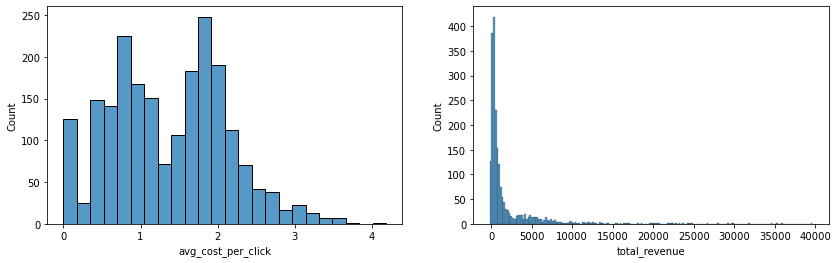

In [6]:
# Fristly we can check the distribution of some features and to see if there exists any significant difference

fig, ax = plt.subplots(1, 2, figsize = (14, 4))

sns.histplot(data = ad_table, x = 'avg_cost_per_click', ax = ax[0])
sns.histplot(data = ad_table, x = 'total_revenue', ax = ax[1])

The distribution of avg_cost_per_click and total_revenue are not even, which means if we use revenue or cost as metric, it will cause bias for the true click through rate. Therefore, we can use the weekly click-through-rate as our metric to choose the top group ads.

In [7]:
ad_table['week'] = ad_table['date'].apply(lambda x: x.isocalendar()[1])
temp = ad_table.groupby(['ad', 'week'])['shown', 'clicked'].sum().reset_index()
temp['weekly_CTR'] = temp['clicked']/temp['shown']
temp = temp.groupby(['ad'])['weekly_CTR'].mean().sort_values(ascending = False)[:5]
temp

ad
ad_group_18    0.098812
ad_group_3     0.094713
ad_group_19    0.093993
ad_group_26    0.091170
ad_group_28    0.089433
Name: weekly_CTR, dtype: float64

The pros of avg_weekly_CTR are:
    1) solved the problem of weekly seasonality in CTR
    2) evaluated the pure efficiency of ads poster, ignored the effect of real product website.
While the cons are:
    1) can't evaluate the final monetary effect of advertisement into profit

### Question 2

For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

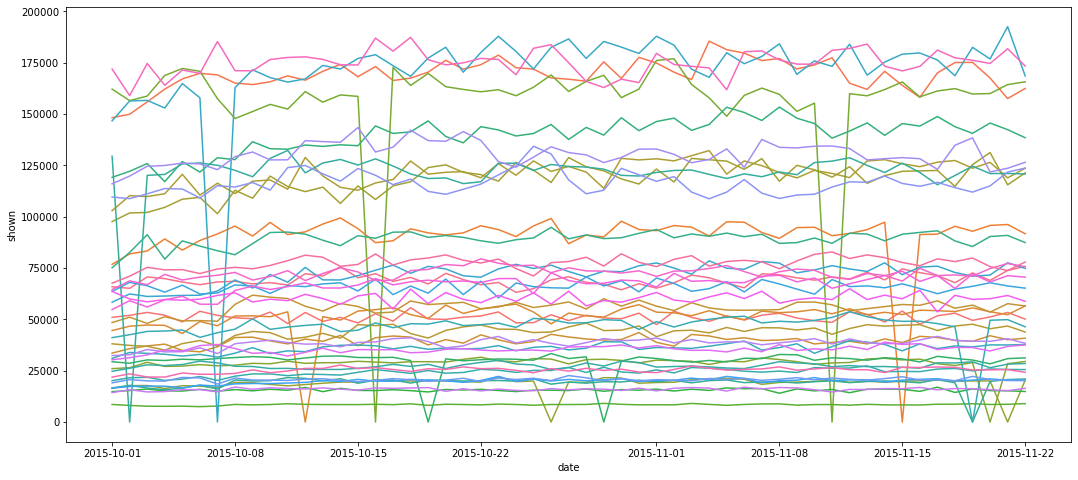

In [8]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.lineplot(data = ad_table, x = 'date', y = 'shown', hue = 'ad')
ax.get_legend().remove()

It's clear that there exists weekly trend in some ad groups. However, these trends are not the same in all groups. Therefore, we need to fit the prediction model for each of them respectively.

In [9]:
ad_table['weekday'] = ad_table['date'].dt.weekday
train_df = ad_table.iloc[: , [6, 1, 7, 8]]
train_df = pd.get_dummies(train_df, columns = ['weekday'])

In [10]:
ad_groups = list(ad_table['ad'].unique())
new_data = pd.DataFrame({'week' : [51], 'weekday_0':[0], 'weekday_1':[1], 'weekday_2':[0],
       'weekday_3':[0], 'weekday_4':[0], 'weekday_5':[0], 'weekday_6':[0]})
ans = []
for i in ad_groups:
    data = train_df[train_df.ad == i]
    model = LinearRegression()
    model.fit(data.iloc[:, 2:], data.iloc[:,1])
    ans.append(int(model.predict(new_data)[0]))

In [11]:
result = pd.DataFrame({'ad_groups' : ad_groups, 'predicted_shown':ans})
result.head(3)

,ad_groups,predicted_shown
0,ad_group_1,73525
1,ad_group_2,50305
2,ad_group_3,177133


### Question 3

Cluster ads into 3 groups: 

the ones whose avg_cost_per_click is going up, 

the ones whose avg_cost_per_click is flat 

and the ones whose avg_cost_per_click is going down.

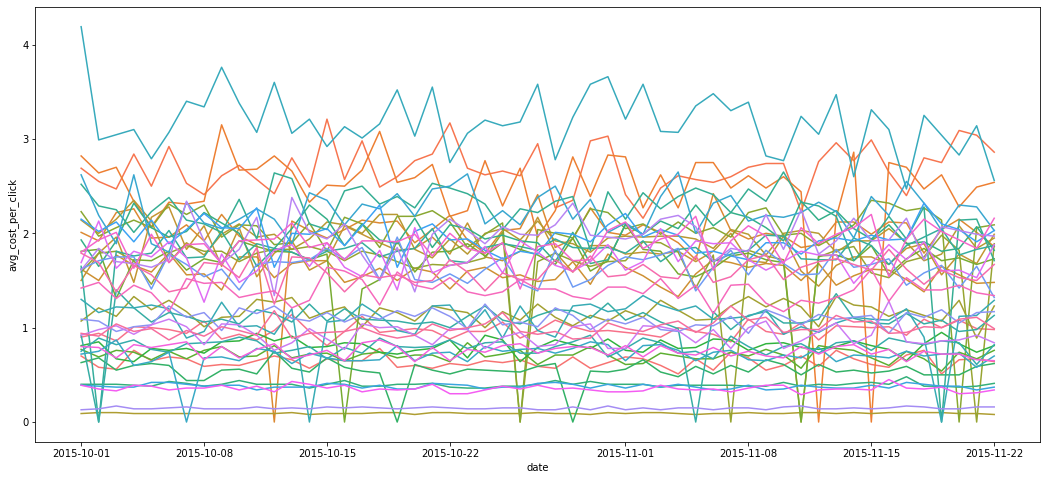

In [12]:
# Create lineplots to have a general view of data distribution first
fig, ax = plt.subplots(figsize = (18, 8))
sns.lineplot(data = ad_table, x = 'date', y = 'avg_cost_per_click', hue = 'ad')
ax.get_legend().remove()

Similar to the distribution of 'shown', we notice that there exists weekly trend in some ad groups. However, these trends are not the same in all groups.

In order to decide the development trend for each group, we can first calculate the weekly average 'avg_cost_per_click' and count total weeks with an increased cost.

In [13]:
ad_table.head(3)

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,week,weekday
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,40,3
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,40,4
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,40,5


In [14]:
temp = ad_table.groupby(['ad', 'week'])['avg_cost_per_click'].mean().reset_index(name = 'weekly_avg')
temp['last_weekly_avg'] = temp['weekly_avg'].shift(1)
temp['last_ad'] = temp['ad'].shift(1)
temp = temp[temp.last_ad == temp.ad]

temp['increased_weekly'] = (temp.weekly_avg - temp.last_weekly_avg)>0
temp.head(3)

,ad,week,weekly_avg,last_weekly_avg,last_ad,increased_weekly
1,ad_group_1,41,0.952857,0.927500,ad_group_1,True
2,ad_group_1,42,0.987143,0.952857,ad_group_1,True
3,ad_group_1,43,0.970000,0.987143,ad_group_1,False


In [15]:
agg_report = temp.groupby(['ad'])['increased_weekly'].sum().reset_index(name = 'increased_weeks')
agg_report = agg_report.sort_values(by = 'increased_weeks', ascending = False)
agg_report

,ad,increased_weeks
0,ad_group_1,5
28,ad_group_35,5
24,ad_group_31,5
11,ad_group_2,5
13,ad_group_21,4
33,ad_group_4,4
32,ad_group_39,4
30,ad_group_37,4
27,ad_group_34,4
25,ad_group_32,4


<AxesSubplot:xlabel='increased_weeks', ylabel='Count'>

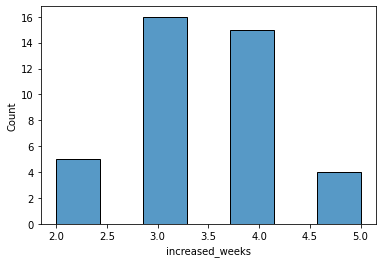

In [16]:
sns.histplot(data = agg_report, x = 'increased_weeks')

Therefore, after considering the weekly trend in each group, we can cluster :

1) ads with an increase with 5 weeks into group of 'going up'; 

2) ads with an increase with 3 or weeks into group of 'flat'; 

3) ads with an increase with 2 weeks into group of 'going down' 